Loading cleaned energy data...
✅ Data loaded successfully!
                            CONS_NO  FLAG       date  consumption
0  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-01         1.34
1  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-02         0.50
2  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-03         3.85
3  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-04         5.67
4  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-05         6.38


/tmp/ipykernel_5812/1463879399.py:39: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  energy_df['pct_change'] = grouped['consumption'].transform(lambda x: x.pct_change().fillna(0))



✅ Feature engineering complete!
                            CONS_NO  FLAG       date  consumption  \
0  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-01         1.34   
1  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-02         0.50   
2  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-03         3.85   
3  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-04         5.67   
4  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-05         6.38   
5  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-06         4.94   
6  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-07         5.33   
7  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-08         5.17   
8  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-09         5.79   
9  0000E78A22CB04533A0D9E1F2FBEEC5D     0 2014-01-10         4.04   

   rolling_mean_3  rolling_std_3  pct_change  lag_1  lag_2  mean_usage  \
0        1.340000       0.000000    0.000000   0.00   0.00    5.320385   
1        0.920000       0.593970   -0.626866   1.34   0.00 

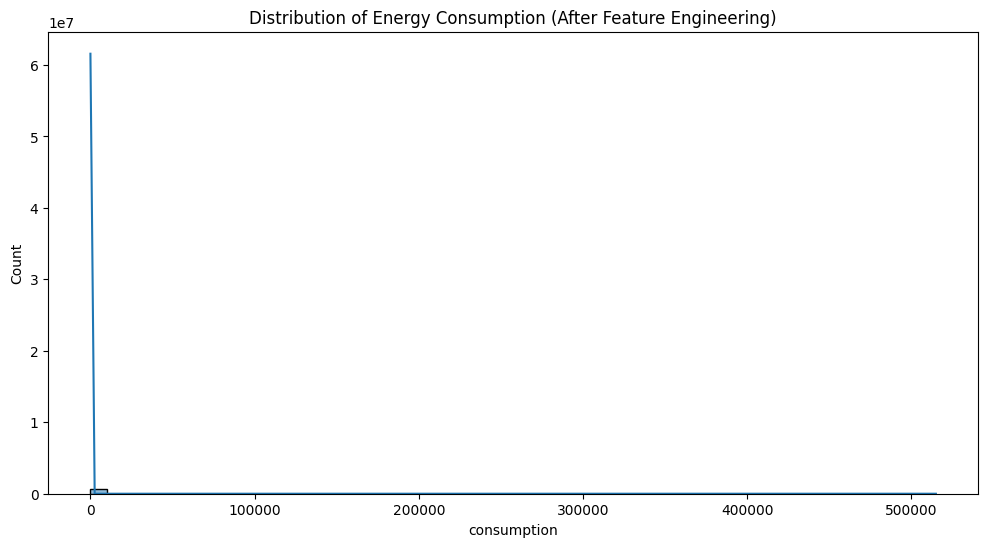

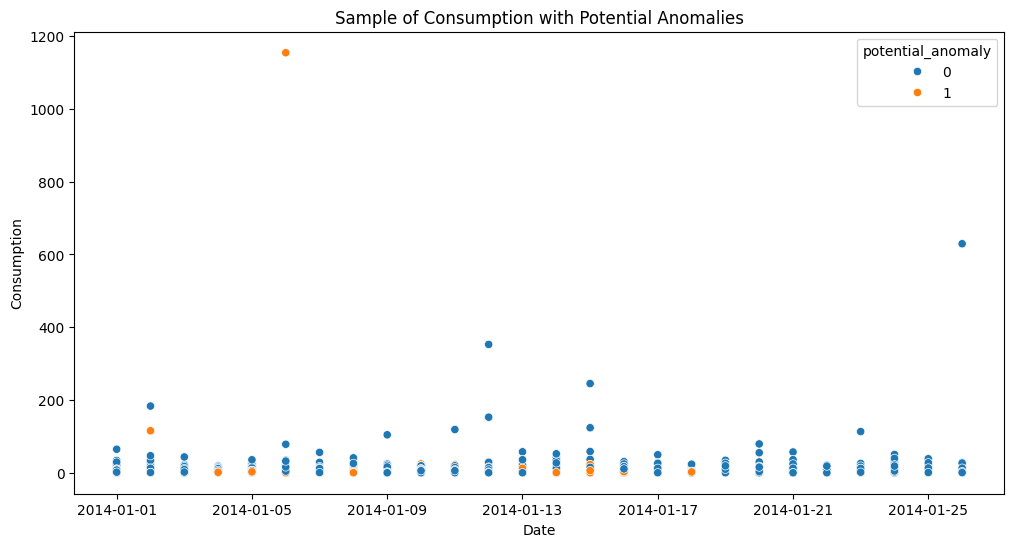


💾 Engineered features saved to: /var/home/kiddomendes/Documents/GitHub/VUT/Project/energy_theft_and_oil_leak/data/energy_features.csv


In [1]:
# 03_feature_engineering_energy.ipynb
# Feature Engineering for Energy Theft Detection

# -----------------------------------------------
# 1️⃣ Import Libraries
# -----------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# -----------------------------------------------
# 2️⃣ Load Cleaned Energy Data
# -----------------------------------------------
DATA_DIR = Path.cwd().parent / 'data'
energy_path = DATA_DIR / 'energy_data_transformed.csv'

print("Loading cleaned energy data...")
energy_df = pd.read_csv(energy_path)

# Convert date column to datetime
energy_df['date'] = pd.to_datetime(energy_df['date'])
print("✅ Data loaded successfully!")
print(energy_df.head())

# -----------------------------------------------
# 3️⃣ Sort and Group Data
# -----------------------------------------------
energy_df = energy_df.sort_values(['CONS_NO', 'date'])
grouped = energy_df.groupby('CONS_NO')

# -----------------------------------------------
# 4️⃣ Create Time-based Features
# -----------------------------------------------
# Compute rolling features per consumer
energy_df['rolling_mean_3'] = grouped['consumption'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
energy_df['rolling_std_3'] = grouped['consumption'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
energy_df['pct_change'] = grouped['consumption'].transform(lambda x: x.pct_change().fillna(0))

# Lag features (previous day’s consumption)
energy_df['lag_1'] = grouped['consumption'].shift(1)
energy_df['lag_2'] = grouped['consumption'].shift(2)

# Fill missing values after shift
energy_df = energy_df.fillna(0)

# -----------------------------------------------
# 5️⃣ Statistical Features (Consumer Level)
# -----------------------------------------------
consumer_stats = energy_df.groupby('CONS_NO')['consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
consumer_stats.rename(columns={'mean':'mean_usage', 'std':'usage_std', 'max':'max_usage', 'min':'min_usage'}, inplace=True)

energy_df = pd.merge(energy_df, consumer_stats, on='CONS_NO', how='left')

# -----------------------------------------------
# 6️⃣ Derived Features
# -----------------------------------------------
energy_df['z_score'] = (energy_df['consumption'] - energy_df['mean_usage']) / (energy_df['usage_std'] + 1e-6)
energy_df['sudden_spike'] = (energy_df['pct_change'] > 0.5).astype(int)
energy_df['sudden_drop'] = (energy_df['pct_change'] < -0.5).astype(int)

# -----------------------------------------------
# 7️⃣ Anomaly Indicator (Preliminary)
# -----------------------------------------------
# Mark potential anomalies (this will later be refined by ML)
energy_df['potential_anomaly'] = ((abs(energy_df['z_score']) > 3) | (energy_df['sudden_spike'] == 1) | (energy_df['sudden_drop'] == 1)).astype(int)

print("\n✅ Feature engineering complete!")
print(energy_df.head(10))

# -----------------------------------------------
# 8️⃣ Visualization
# -----------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(energy_df['consumption'], bins=50, kde=True)
plt.title('Distribution of Energy Consumption (After Feature Engineering)')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='consumption', hue='potential_anomaly', data=energy_df.sample(2000))
plt.title('Sample of Consumption with Potential Anomalies')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.show()

# -----------------------------------------------
# 9️⃣ Save Engineered Dataset
# -----------------------------------------------
output_path = DATA_DIR / 'energy_features.csv'
energy_df.to_csv(output_path, index=False)
print(f"\n💾 Engineered features saved to: {output_path}")
